# 01_Regression Review

#### 실습목표 I<br>
1. Linear Regression 을 이해하고 사용해본다.
2. KNN Regression 을 이해하고 사용해본다.
3. Artificial Neural Network Regression을 이해하고 사용해본다.

#### 실습목표 II<br>
1. Pandas 라이브러리로 csv 파일을 불러오고, 전처리할 수 있다.
2. Pandas로 전처리한 파일을 Numpy array로 바꿀 수 있다.
3. Scikit-learn을 통해 간단히 머신러닝을 사용해볼 수 있다.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. 데이터 이해

### 1.1 Data 가져오기

데이터 설명 : https://www.kaggle.com/c/bike-sharing-demand/data

In [2]:
data_path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/bike_sharing.csv'
rides = pd.read_csv(data_path)

### 1.2 데이터 둘러보기

In [3]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [4]:
rides.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In [5]:
rides.shape

(17379, 17)

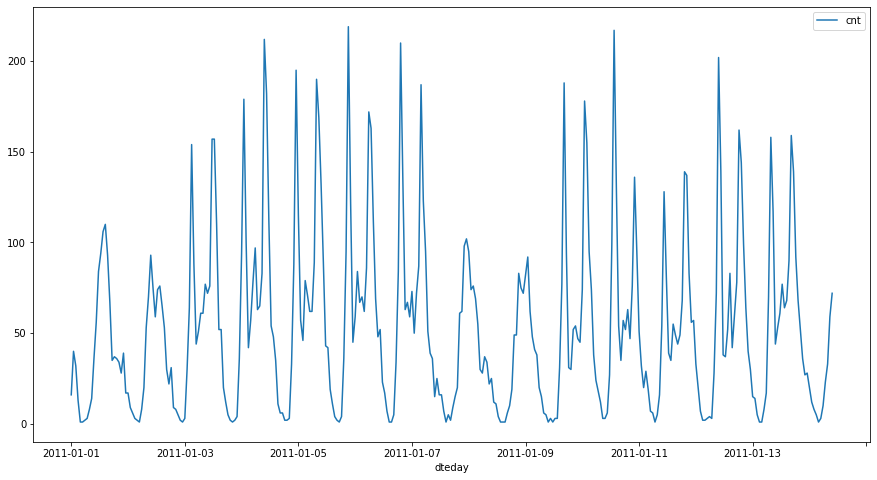

In [6]:
# 특정 기간을 정해서 차트를 그려봅시다.

days = 14
rides[:24 * days].plot(x='dteday', y='cnt',figsize = (15, 8))
plt.show()

## 2. 데이터 준비

### 2.1 Dummy Variable

Season, weathersit, mnth, hr, weekday 등의 Categorical Variable들은 모델에 넣기 전에 Binary dummy variable로 만들 필요가 있다.

그리고 사용하지 않을 변수들은 제거하자.


익혀야 할 방법들
pd.get_dummies, pd.concat, (Pandas Dataframe).drop

In [7]:
# dummy variables 대상 이름 담기
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']

# for loop 반복실행하며 dummy variable 만들고, 기존 데이터셋에 합치기
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

# 기존 변수, 불필요한 변수 제거하기    
fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3,weathersit_4,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,hr_0,hr_1,hr_2,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### 2.2 데이터 분할 
맨 마지막의 21일을 test_set으로, 그리고 마지막의 81~22 (60일)을 validation set으로, 나머지를 Training set으로 둔다.<br>



In [8]:
test_data = data[-21*24:]
val_data = data[-81*24:-21*24]
train_data = data[:-81*24]

# 우리는 타겟 중 첫번째 컬럼(cnt)만 사용할 것이다.
target_fields = ['cnt', 'casual', 'registered']
test_features, test_target = test_data.drop(target_fields, axis=1), test_data['cnt']
val_features, val_target = val_data.drop(target_fields, axis=1), val_data['cnt']
train_features, train_target = train_data.drop(target_fields, axis=1), train_data['cnt']


### 2.3 스케일링 : Scaling features

mean shifting & Scaling : 평균을 0으로, 표준편차를 1로<br>



In [9]:
# 필요한 함수 불러오기
from sklearn.preprocessing import StandardScaler

# 선언하기
scaler = StandardScaler()

# 스케일링 함수 만들기(모델링?)
scaler.fit(train_features)

# 적용하기
train_features = scaler.transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)


### 2.4 Pandas Dataframe to Numpy array

Scikit-learn 만 사용한다면 사실 필요없을 수 있는 과정이다. 하지만, 차후 Tensorflow로 넘어간다면 Numpy를 사용해야만 한다. (Pandas데이터 타입을 받질 못한다.)<br>

In [10]:
# StandardScaler 를 이용하면 결과가 np.array로 나옴.
# 그러므로 Target만 np.array로....
train_target, val_target, test_target = train_target.values, val_target.values, test_target.values

In [11]:
train_features.shape, train_target.shape

((15435, 56), (15435,))

## 3. Model Training : Multivariate Linear Regression

이제 데이터가 준비 되었습니다.  
2개 이상의 입력변수를 이용한 Multivariate Linear Regression을 사용해 봅시다.

### 3.1 필요한 함수 로딩

In [12]:
# multivariate regression을 해보자!

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

### 3.2 모델링 & 검증

In [13]:
# 1) 모델 준비
multi_regression = LinearRegression()

# 2) 모델 training
# Test셋의 첫번째 컬럼(cnt)만 사용할 것이다. 
multi_regression.fit(train_features, train_target )

# 3) Training & Validation set에서의 예측
val_pred = multi_regression.predict(val_features)

In [14]:
# 회귀 계수를 살짝 살펴봅시다. 
print(multi_regression.coef_)

[ 4.49723439e+01 -2.80486753e+00  4.06676671e+01 -1.62632720e+01
 -4.08540248e+00 -1.33308432e+13 -1.37656772e+13 -1.38458780e+13
 -1.13169876e+13  3.37680639e+14  3.09928661e+14  1.98636587e+14
  9.98083793e+12 -3.66400006e+14 -3.56052320e+14 -3.71413331e+14
 -3.67319239e+14 -3.73099067e+14 -3.67663057e+14 -3.73099067e+14
 -3.71638772e+14 -3.67319239e+14 -3.06337232e+14 -2.66404546e+14
 -2.70247334e+14 -1.17169248e+14 -1.17082341e+14 -1.16296707e+14
 -1.14973134e+14 -1.14795291e+14 -1.16471837e+14 -1.17169248e+14
 -1.17342830e+14 -1.17256077e+14 -1.17256077e+14 -1.17256077e+14
 -1.17256077e+14 -1.17342830e+14 -1.17342830e+14 -1.17342830e+14
 -1.17342830e+14 -1.17429507e+14 -1.17429507e+14 -1.17256077e+14
 -1.17256077e+14 -1.17256077e+14 -1.17256077e+14 -1.17256077e+14
 -1.17256077e+14  5.95447417e+14  5.95559350e+14  5.94213411e+14
  5.93312788e+14  5.92183243e+14  5.93763434e+14  5.96564893e+14]


In [15]:
rides.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt', 'season_1', 'season_2', 'season_3',
       'season_4', 'weathersit_1', 'weathersit_2', 'weathersit_3',
       'weathersit_4', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5',
       'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12',
       'hr_0', 'hr_1', 'hr_2', 'hr_3', 'hr_4', 'hr_5', 'hr_6', 'hr_7', 'hr_8',
       'hr_9', 'hr_10', 'hr_11', 'hr_12', 'hr_13', 'hr_14', 'hr_15', 'hr_16',
       'hr_17', 'hr_18', 'hr_19', 'hr_20', 'hr_21', 'hr_22', 'hr_23',
       'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6'],
      dtype='object')

In [16]:
# Validation set에서의 성능 확인
print("Mean Squared Error on Validation set : {0:.5f}".format(mean_squared_error(val_target, val_pred)  ))

Mean Squared Error on Validation set : 15280.90233


### 3.3 Test

In [17]:
# test set 예측
multi_regressions = multi_regression.predict(test_features)


In [18]:
multi_regressions

array([ 1.88789605e+02,  1.41289605e+02,  5.36646045e+01,  9.46646045e+01,
        8.21646045e+01,  1.78960452e+00,  4.51646045e+01,  8.16460452e+00,
        1.25164605e+02,  2.63914605e+02,  3.98664605e+02,  2.64664605e+02,
        2.19164605e+02,  2.37789605e+02,  2.68914605e+02,  2.86914605e+02,
        2.62289605e+02,  2.74164605e+02,  3.35414605e+02,  4.85414605e+02,
        4.59164605e+02,  3.51164605e+02,  2.74164605e+02,  2.24914605e+02,
        1.81414605e+02,  1.41539605e+02,  1.13164605e+02,  8.19146045e+01,
        8.14146045e+01,  6.12896045e+01,  6.19146045e+01,  6.71646045e+01,
        1.19914605e+02,  2.50664605e+02,  3.83914605e+02,  2.51414605e+02,
        2.03664605e+02,  2.38039605e+02,  2.89664605e+02,  2.93414605e+02,
        2.65539605e+02,  2.73914605e+02,  3.34164605e+02,  4.76414605e+02,
        4.53414605e+02,  3.35414605e+02,  2.69664605e+02,  2.10664605e+02,
        1.75664605e+02,  1.25164605e+02,  9.74146045e+01,  7.79146045e+01,
        6.46646045e+01,  

Mean Squared Error on Test set : 11700.02246


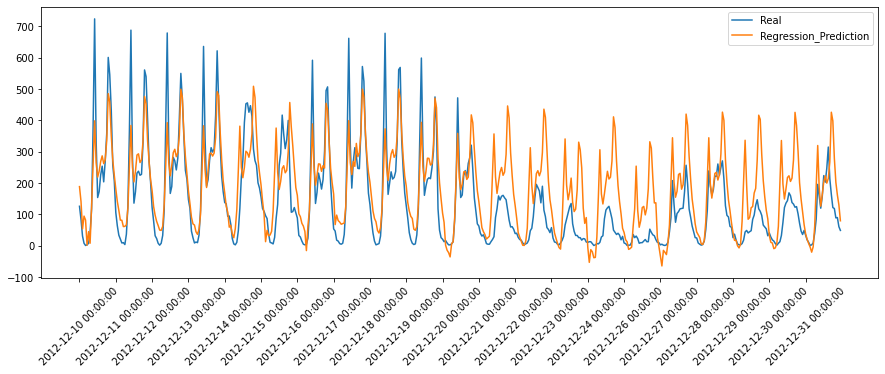

In [19]:
# 예측 결과와 실제값 비교 차트

fig, ax = plt.subplots(figsize=(15,5))

ax.plot(test_target, label = 'Real')
ax.plot(multi_regressions, label = 'Regression_Prediction')

ax.legend()

# x축 날짜 값 넣기
dates = pd.to_datetime(rides.iloc[test_data.index]['dteday'])
ax.set_xticks(np.arange(len(dates))[::24])
ax.set_xticklabels(dates[::24], rotation=45)

print("Mean Squared Error on Test set : {0:.5f}".format(mean_squared_error(test_target, multi_regressions)  ))

plt.show()

In [20]:
# :: ?

[1,22,2,3,4,2,21,3,4][::3]

[1, 3, 21]

#### MAPE로도 평가해 봅시다.
* MSE가 오차의 양을 의미한다면
* MAPE는 오차의 비율을 의미합니다.

In [21]:
# 안타깝게도 바로 사용 가능한 함수가 없으므로 직접 만들어 봅시다.
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))


In [22]:
# 사용해 봅시다.
print("Mean Absolute Percentage Error on Test set : {0:.5f}".format(mean_absolute_percentage_error(test_target, multi_regressions)  ))


Mean Absolute Percentage Error on Test set : 2.50110


[matplotlib 기본을 잘 설명한 곳](https://datascienceschool.net/view-notebook/d0b1637803754bb083b5722c9f2209d0/)

## 4. 실습

### 실습 1 Model Training : KNN Regression

[K-Nearest Neighbors Regression](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor)


In [27]:
# Nearest-Neighbor Regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [29]:
# 모델 준비
knn_regression = KNeighborsRegressor()

# 모델 training
# Test셋의 첫번째 컬럼(cnt)만 사용할 것이다. 
knn_regression.fit(train_features, train_target)

# Validation set에서의 예측값 준비
pred_val = knn_regression.predict(val_features)

In [30]:
# Validation set에서의 성능 확인
print(mean_absolute_error(val_target, pred_val))
print(mean_absolute_percentage_error(val_target, pred_val))

81.20069444444445
0.43001478885461825


59.145634920634926


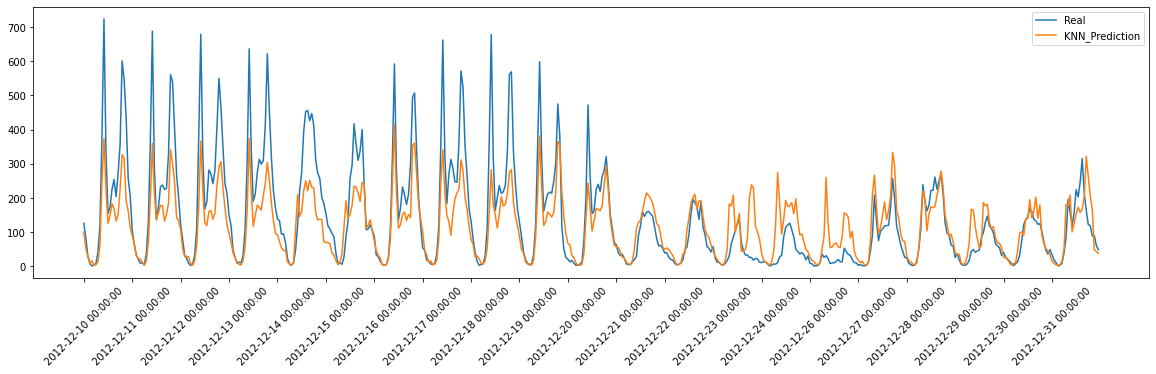

In [32]:
# 테스트 셋을 이용하여 예측하고, 실제값과 예측값을 시각화 해 봅시다.
# 실제값과 예측값을 비교해 봅시다.
knn_predictions = knn_regression.predict(test_features)

# 결과 시각화
fig, ax = plt.subplots(figsize=(20,5))

ax.plot(test_target, label = 'Real')
ax.plot(knn_predictions, label = 'KNN_Prediction')
ax.legend()

# x축 날짜 값 넣기
dates = pd.to_datetime(rides.iloc[test_data.index]['dteday'])
ax.set_xticks(np.arange(len(dates))[::24])
ax.set_xticklabels(dates[::24], rotation=45)

# test set에 대한 MSE값을 뽑아 봅시다.
print(mean_absolute_error(test_target, knn_predictions)  )
plt.show()

### 실습2 : ANN을 이용하여 모델링하고 예측하고, 결과를 평가해봅시다.

[MLPRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor)와 [Neural Network models (supervised)](http://scikit-learn.org/stable/modules/neural_networks_supervised.html)를 적극 참고하자  
여기서는 실행만 해보자.


In [ ]:
# 필요한 알고리즘 불러오기

from sklearn.     import      

In [ ]:
# 모델 준비
neural_regression =      (hidden_layer_sizes=(32),
                                 random_state=2018,
                                 verbose = True
                                )

# 모델 training
 

# Validation set에서의 예측값 준비 
    

In [ ]:
# Training & Validation set에서의 성능 확인
print(mean_absolute_error(    ,     ))

In [ ]:
# 테스트 셋을 이용하여 예측하고, 실제값과 예측값을 시각화 해 봅시다.
nn_pred      = neural_regression.    (      )

# 결과 시각화
fig, ax = plt.subplots(figsize=(20,5))

ax.plot(test_target, label = 'Real')
ax.plot(nn_pred, label = 'KNN_Prediction')
ax.legend()

# x축 날짜 값 넣기
dates = pd.to_datetime(rides.iloc[test_data.index]['dteday'])
ax.set_xticks(np.arange(len(dates))[::24])
ax.set_xticklabels(dates[::24], rotation=45)


# test set에 대한 MSE 값을 뽑아 봅시다.
print(mean_absolute_error(test_target, nn_pred)  )
plt.show()